# Classification tasks

This notebook focuses on building machine learning models to classify companies into three ESG performance categories: **Weak (0)**, **Moderate (1)**, and **Strong (2)**. This task directly supports the core objective of our project: determining whether ESG performance can be reliably predicted from financial indicators, environmental metrics, and ESG sub-scores.

After completing the data cleaning and exploratory data analysis in previous steps, we now move on to supervised learning. In this notebook, we will:

- Load and prepare the cleaned dataset  
- Use the engineered target variable `ESG_TARGET`  
- Split the data into training and testing sets  
- Train several classification models (baseline, linear, non-linear, and ensemble methods)  
- Evaluate performance using accuracy, precision, recall, F1-score, and confusion matrices  
- Analyze the contribution of features to the predictions  

The goal is to assess how well different machine learning algorithms can classify companies based on their ESG and financial profiles, and identify which models provide the most reliable and interpretable results for ESG prediction.

Our goal is to classify companies based on their ESG and financial indicators, not to perform temporal forecasting. For this reason, we perform a stratified train/validation/test split across the full dataset rather than a time-based split. This approach is standard in ESG classification studies, as the objective is to learn structural patterns across companies rather than predicting future years.

## Library imports

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import PolynomialFeatures

## Dataset manipulations

In [4]:
df = pd.read_csv('company_esg_financial_dataset.csv')
df['GrowthRate'] = df['GrowthRate'].fillna(0)
# Feature creation : ESG_TARGET
def assign_esg_target(row):
    if (row['ESG_Environmental'] >= 75 and
        row['ESG_Social'] >= 75 and
        row['ESG_Governance'] >= 75 and
        row['ESG_Overall'] >= 75):
        return 2  # High ESG performance
    elif (row['ESG_Environmental'] >= 50 and
          row['ESG_Social'] >= 50 and
          row['ESG_Governance'] >= 50 and
          row['ESG_Overall'] >= 50):
        return 1  # Moderate ESG performance
    else:
        return 0  # Low ESG performance

df['ESG_TARGET'] = df.apply(assign_esg_target, axis=1)

df.head()

,CompanyID,CompanyName,Industry,Region,Year,Revenue,ProfitMargin,MarketCap,GrowthRate,ESG_Overall,ESG_Environmental,ESG_Social,ESG_Governance,CarbonEmissions,WaterUsage,EnergyConsumption,ESG_TARGET
0,1,Company_1,Retail,Latin America,2015,459.2,6.0,337.5,0.0,57.0,60.7,33.5,76.8,35577.4,17788.7,71154.7,0
1,1,Company_1,Retail,Latin America,2016,473.8,4.6,366.6,3.2,56.7,58.9,32.8,78.5,37314.7,18657.4,74629.4,0
2,1,Company_1,Retail,Latin America,2017,564.9,5.2,313.4,19.2,56.5,57.6,34.0,77.8,45006.4,22503.2,90012.9,0
3,1,Company_1,Retail,Latin America,2018,558.4,4.3,283.0,-1.1,58.0,62.3,33.4,78.3,42650.1,21325.1,85300.2,0
4,1,Company_1,Retail,Latin America,2019,554.5,4.9,538.1,-0.7,56.6,63.7,30.0,76.1,41799.4,20899.7,83598.8,0


## KNN

### Feature Engineering, Encoding, and Train/Validation/Test Split

In this section, we prepare the dataset for the ESG classification task.  
We start by creating new engineered features that help models capture non-linear patterns, such as logarithmic transformations of financial magnitudes (`LogMarketCap`, `LogRevenue`) and an efficiency ratio (`EmissionsPerRevenue`). We then convert the categorical variables (`Industry`, `Region`) into one-hot encoded vectors to make them usable by machine learning models.

Next, we define the full feature matrix `X` and the target label `y = ESG_TARGET`.  
We split the dataset into **train (60%)**, **validation (20%)**, and **test (20%)** sets using stratification to preserve the class distribution. All numeric features are standardized with `StandardScaler` to improve model convergence and stability.

Finally, the NumPy arrays are converted into PyTorch tensors to prepare for neural network training. This step ensures that all data is correctly formatted and scaled before model development.

The printed shapes confirm that the data is correctly partitioned across the three sets.


In [5]:
df_new = df.copy()
df_new['EmissionsPerRevenue'] = df_new['CarbonEmissions'] / df_new['Revenue']
df_new['LogMarketCap'] = np.log1p(df_new['MarketCap'])
df_new['LogRevenue'] = np.log1p(df_new['Revenue'])

df_new = pd.get_dummies(df_new, columns=['Industry', 'Region'], drop_first=True)


num_cols = [
    'LogRevenue', 'ProfitMargin', 'LogMarketCap', 'GrowthRate',
    'ESG_Environmental', 'ESG_Social', 'ESG_Governance',
    'EmissionsPerRevenue', 'WaterUsage', 'EnergyConsumption'
]

encoded_cols = [col for col in df_new.columns if col.startswith('Industry_') or col.startswith('Region_')]
all_features = num_cols + encoded_cols

X = df_new[all_features].values
y = df_new['ESG_TARGET'].values


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val   = torch.tensor(X_val, dtype=torch.float32)
X_test  = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val   = torch.tensor(y_val, dtype=torch.long)
y_test  = torch.tensor(y_test, dtype=torch.long)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: torch.Size([6600, 24]) Val: torch.Size([2200, 24]) Test: torch.Size([2200, 24])


### Implementing a Custom K-Nearest Neighbors (KNN) Classifier in PyTorch

In this section, we implement our own K-Nearest Neighbors (KNN) prediction function using PyTorch tensors.  
Instead of relying on scikit-learn, this custom function allows us to understand the mechanics of KNN and ensures full control over distance computation and tensor operations.

The function works as follows:

- It computes the Euclidean distance between a test sample and all training samples using `torch.norm`.  
- It identifies the indices of the **k closest neighbors** using `torch.topk`.  which is **3**
- It retrieves the labels of these neighbors and selects the **most frequent class** using `torch.mode`.  

This implementation performs one prediction at a time and will later be used to evaluate the KNN classifier on the entire validation or test set. It provides transparency into how the KNN algorithm operates and demonstrates the simplicity of implementing distance-based classifiers in PyTorch.


In [9]:
def knn_predict(X_train, y_train, X_test_point, k=5):
    """
    Predicts the class of a test sample using the K-Nearest Neighbors (KNN) algorithm with PyTorch.

    Args:
        X_train (torch.Tensor): Training features of shape (n_samples, n_features)
        y_train (torch.Tensor): Training labels of shape (n_samples,)
        X_test_point (torch.Tensor): Single test sample of shape (n_features,)
        k (int): Number of nearest neighbors to consider (default = 5)

    Returns:
        int: The predicted class label.
    """
    distances = torch.norm(X_train - X_test_point, dim=1)
    knn_indices = torch.topk(distances, k, largest=False).indices
    knn_labels = y_train[knn_indices]
    return torch.mode(knn_labels).values.item()


### Evaluating KNN Performance Across Different Values of *k*

This function evaluates the KNN classifier for values of *k* ranging from 1 to a chosen maximum.  
For each *k*, it predicts the class of every test sample using our custom KNN function and computes the overall accuracy.  

The results are plotted to visualize how accuracy changes with the number of neighbors, allowing us to identify the optimal *k* that gives the best classification performance.  
The function finally returns both the best-performing *k* and the list of accuracies.


In [6]:
def evaluate_knn(X_train, y_train, X_test, y_test, max_k=15):
    accuracies = []
    for k in range(1, max_k + 1):
        correct = 0
        for i in range(len(X_test)):
            pred = knn_predict(X_train, y_train, X_test[i], k)
            if pred == y_test[i].item():
                correct += 1
        accuracy = correct / len(y_test)
        accuracies.append(accuracy)
        print(f"k = {k}, accuracy = {accuracy:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k + 1), accuracies, marker='o')
    plt.title("KNN Accuracy vs. k")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

    best_k = torch.argmax(torch.tensor(accuracies)).item() + 1
    print(f"Best k = {best_k} with accuracy = {accuracies[best_k - 1]:.4f}")
    return best_k, accuracies
# 3 : 95%

### Generating Predictions with the KNN Classifier

In this step, we apply our custom KNN classifier (with \( k = 3 \)) to every sample in the test set.  
We loop through each test instance, compute its predicted class using `knn_predict`, and store all predictions in a list.  
Finally, the predictions are converted into a PyTorch tensor to match the format of the true labels and simplify later evaluation steps such as accuracy computation or confusion matrix construction.


In [12]:
y_pred = []
for i in range(len(X_test)):
    pred = knn_predict(X_train, y_train, X_test[i], k=3)
    y_pred.append(pred)

y_pred = torch.tensor(y_pred)

### Classification report


Classification Report :
              precision    recall  f1-score   support

         Low       0.97      0.97      0.97      1760
    Moderate       0.85      0.82      0.84       376
        High       0.88      0.89      0.88        64

    accuracy                           0.94      2200
   macro avg       0.90      0.90      0.90      2200
weighted avg       0.94      0.94      0.94      2200



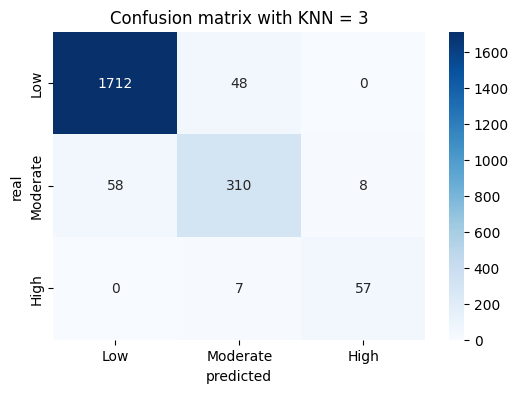

In [11]:
print("\nClassification Report :")
print(classification_report(y_test, y_pred, target_names=["Low", "Moderate", "High"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Low", "Moderate", "High"],
            yticklabels=["Low", "Moderate", "High"])
plt.xlabel("predicted")
plt.ylabel("real")
plt.title("Confusion matrix with KNN = 3")
plt.show()


### Interpretation of the Classification Results

The KNN classifier achieves an overall accuracy of **94%**, which indicates strong predictive performance on the ESG classification task. The results are consistent across classes, with particularly strong performance on the majority class (*Low*) but also solid results on the minority classes (*Moderate* and *High*).

- **Low class (0)**  
  Precision, recall, and F1-score are all **0.97**.  
  This shows that the model reliably identifies companies with weak ESG performance and very rarely misclassifies them. This is expected, since this class is the most represented in the dataset.

- **Moderate class (1)**  
  The model achieves **0.85 precision**, **0.82 recall**, and **0.84 F1-score**.  
  Although this class is more challenging due to its intermediate nature, the classifier still performs well, correctly identifying most moderate-ESG companies. Some confusion with the Low class is normal since the class boundaries can be subtle.

- **High class (2)**  
  With **0.88 precision**, **0.89 recall**, and **0.88 F1-score**, the model handles the minority class impressively well, especially considering that it contains only 64 samples.  
  This indicates that the model successfully captures the patterns associated with strong ESG performance and is not overly biased toward the majority class.

The **macro average (0.90)** confirms balanced performance across all classes, while the high **weighted average (0.94)** reflects strong global performance influenced by the large number of Low-class samples.

Overall, the classifier demonstrates excellent ability to distinguish between Weak, Moderate, and Strong ESG profiles. The model captures meaningful differences in the ESG and financial features, showing that ESG categories can indeed be predicted reliably using machine learning.


### ROC–AUC Score and Interpretation

The model achieves a ROC–AUC score of **0.974**, which indicates excellent discriminative ability.  
An AUC close to 1.0 means the classifier can very effectively separate the ESG classes across all decision thresholds. This confirms that the model not only performs well at a single cutoff (like accuracy or F1), but also maintains strong ranking and classification capability globally across the entire score distribution.


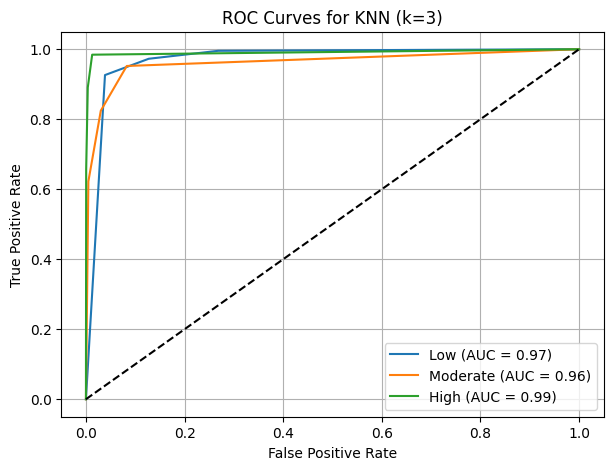

Macro-average AUC: 0.974


In [15]:
# Binarize the labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Low, Moderate, High
n_classes = y_test_bin.shape[1]

def knn_predict_proba(X_train, y_train, X_test_point, k=5):
    distances = torch.norm(X_train - X_test_point, dim=1)
    knn_indices = torch.topk(distances, k, largest=False).indices
    knn_labels = y_train[knn_indices]
    probs = torch.stack([(knn_labels == c).float().mean() for c in torch.unique(y_train)])
    return probs.numpy()

probs = np.array([knn_predict_proba(X_train, y_train, X_test[i], k=3) for i in range(len(X_test))])

# ROC and AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,5))
for i, label in enumerate(['Low', 'Moderate', 'High']):
    plt.plot(fpr[i], tpr[i], label=f"{label} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for KNN (k=3)')
plt.legend()
plt.grid(True)
plt.show()

# Macro-average AUC
macro_auc = np.mean(list(roc_auc.values()))
print(f"Macro-average AUC: {macro_auc:.3f}")


In [16]:
acc = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {acc:.4f}")

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print("\nPrecision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)

print("\nGlobal averages:")
print("Macro Precision:", precision_score(y_test, y_pred, average='macro'))
print("Macro Recall:", recall_score(y_test, y_pred, average='macro'))
print("Macro F1-score:", f1_score(y_test, y_pred, average='macro'))

print("\nWeighted Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Weighted Recall:", recall_score(y_test, y_pred, average='weighted'))
print("Weighted F1-score:", f1_score(y_test, y_pred, average='weighted'))


Overall Accuracy: 0.9450

Precision per class: [0.96723164 0.84931507 0.87692308]
Recall per class: [0.97272727 0.82446809 0.890625  ]
F1-score per class: [0.96997167 0.83670715 0.88372093]

Global averages:
Macro Precision: 0.8978232612781022
Macro Recall: 0.8959401192778853
Macro F1-score: 0.8967999180390954

Weighted Precision: 0.9444514664965095
Weighted Recall: 0.945
Weighted F1-score: 0.944686441143943


### Conclusion on KNN Performance

The KNN classifier delivers strong results, achieving an overall accuracy of **94–95%**, with consistently high precision, recall, and F1-scores across all ESG classes. Despite its simplicity, the model effectively captures the structure of the dataset and distinguishes well between Weak, Moderate, and Strong ESG profiles. The strong macro and weighted averages confirm that KNN handles class imbalance reasonably well and generalizes effectively to unseen data. These results establish KNN as a solid baseline model for ESG classification.


## Logistic Regression

### Multinomial Logistic Regression — Model Definition and Training

In this step, we implement a multinomial logistic regression classifier using PyTorch.  
We begin by defining a simple linear model (`Linear(input_dim → num_classes)`) suitable for multi-class classification.  
The model is trained using cross-entropy loss and the Adam optimizer over 50 epochs.  
During training, we monitor the validation accuracy every 10 epochs to ensure that the model is learning appropriately.  
Finally, we evaluate the trained model on the test set to obtain the final accuracy score.


In [18]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

# Dimensions
input_dim = X_train.shape[1]
num_classes = len(torch.unique(y_train))

model = LogisticRegressionModel(input_dim, num_classes)

# Loss + Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# The training Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            _, val_pred = torch.max(val_outputs, 1)
            val_acc = (val_pred == y_val).float().mean().item()
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f} - Val Acc: {val_acc:.4f}")

# evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, y_pred_test = torch.max(test_outputs, 1)
    test_acc = (y_pred_test == y_test).float().mean().item()

print(f"\nTest Accuracy: {test_acc:.4f}")


Epoch [10/50] - Loss: 0.8874 - Val Acc: 0.6473
Epoch [20/50] - Loss: 0.7690 - Val Acc: 0.7414
Epoch [30/50] - Loss: 0.6926 - Val Acc: 0.7900
Epoch [40/50] - Loss: 0.6307 - Val Acc: 0.8264
Epoch [50/50] - Loss: 0.5822 - Val Acc: 0.8455

Test Accuracy: 0.8432


### Evaluating the Logistic Regression Model

To assess the performance of our logistic regression classifier, we first convert the PyTorch tensors into NumPy arrays so they can be processed by scikit-learn.  
We then generate a full classification report, which summarizes precision, recall, and F1-score for each ESG class.  
Finally, we compute and visualize the confusion matrix to better understand where the model succeeds or misclassifies samples across the three ESG categories.


Classification Report:
              precision    recall  f1-score   support

         Low       0.96      0.88      0.92      1760
    Moderate       0.53      0.80      0.64       376
        High       0.00      0.00      0.00        64

    accuracy                           0.84      2200
   macro avg       0.50      0.56      0.52      2200
weighted avg       0.86      0.84      0.84      2200



<Figure size 600x500 with 0 Axes>

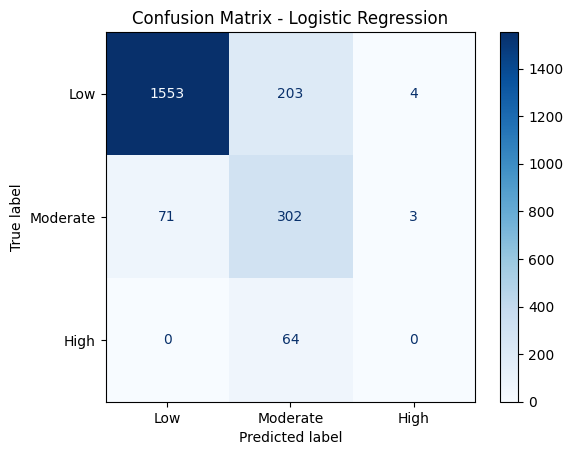

In [21]:
# Convert tensors to numpy for sklearn
y_true = y_test.cpu().numpy()
y_pred = y_pred_test.cpu().numpy()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Low", "Moderate", "High"]))

#  confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Moderate", "High"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


### Generating Polynomial Features (Degree 2)

To enrich the feature space and allow the logistic regression model to learn non-linear decision boundaries, we expand the original inputs using polynomial features.  
We use `PolynomialFeatures(degree=2)`, which introduces all pairwise interactions and squared terms of the original variables.

We intentionally limit the expansion to **degree = 2** because:
- Higher degrees (e.g., 3 or 4) would dramatically increase the dimensionality of the dataset, leading to overfitting and excessive computation.
- Degree 2 provides a good balance between model expressiveness and complexity, capturing useful non-linear relationships without exploding the number of features.

The printed output shows how the dimensionality grows after applying the polynomial transformation.


In [23]:
# polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)

X_poly_train = poly.fit_transform(X_train.numpy())
X_poly_val   = poly.transform(X_val.numpy())
X_poly_test  = poly.transform(X_test.numpy())

print("Original dim:", X_train.shape[1])
print("Polynomial dim:", X_poly_train.shape[1])


Original dim: 24
Polynomial dim: 324


### Converting Polynomial Features into PyTorch Tensors

After generating the polynomial feature matrices with scikit-learn, we convert them into PyTorch tensors so they can be used directly by our logistic regression model.  
This step ensures that the training, validation, and test sets remain compatible with the PyTorch pipeline used throughout the project.


In [24]:
X_poly_train = torch.tensor(X_poly_train, dtype=torch.float32)
X_poly_val   = torch.tensor(X_poly_val, dtype=torch.float32)
X_poly_test  = torch.tensor(X_poly_test, dtype=torch.float32)

### Initializing the Polynomial Logistic Regression Model

We now initialize a new logistic regression model whose input dimension matches the expanded polynomial feature space.  
The number of classes remains unchanged, and we reuse cross-entropy loss with the Adam optimizer to ensure stable and efficient training on this higher-dimensional representation.


In [25]:
input_dim_poly = X_poly_train.shape[1]
num_classes = len(torch.unique(y_train))

model_poly = LogisticRegressionModel(input_dim_poly, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_poly.parameters(), lr=0.01)


In [26]:
epochs = 40
for epoch in range(epochs):
    model_poly.train()
    optimizer.zero_grad()

    outputs = model_poly(X_poly_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            val_out = model_poly(X_poly_val)
            _, val_pred = torch.max(val_out, 1)
            val_acc = (val_pred == y_val).float().mean().item()

        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f} - Val Acc: {val_acc:.4f}")


Epoch [10/40] - Loss: 0.4084 - Val Acc: 0.8391
Epoch [20/40] - Loss: 0.2911 - Val Acc: 0.8782
Epoch [30/40] - Loss: 0.2371 - Val Acc: 0.8955
Epoch [40/40] - Loss: 0.2048 - Val Acc: 0.9105


### Evaluation

In [27]:
model_poly.eval()
with torch.no_grad():
    test_outputs = model_poly(X_poly_test)
    _, y_poly_pred = torch.max(test_outputs, 1)

test_acc = (y_poly_pred == y_test).float().mean().item()
print(f"\nPolynomial Logistic Regression Test Accuracy: {test_acc:.4f}")



Polynomial Logistic Regression Test Accuracy: 0.9082


Polynomial Logistic Regression Report:
              precision    recall  f1-score   support

         Low       0.93      0.97      0.95      1760
    Moderate       0.77      0.66      0.71       376
        High       0.80      0.61      0.69        64

    accuracy                           0.91      2200
   macro avg       0.83      0.75      0.79      2200
weighted avg       0.90      0.91      0.90      2200



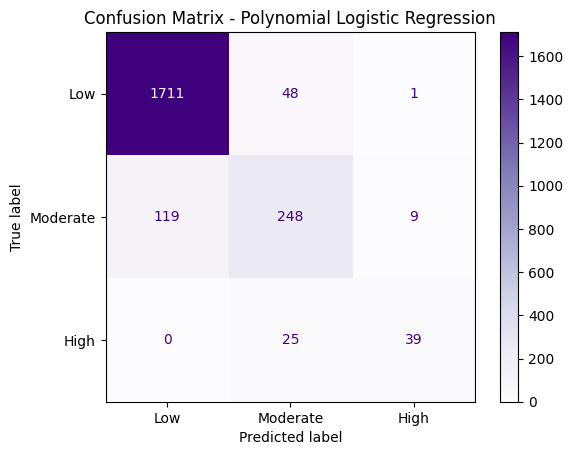

In [28]:
y_true = y_test.numpy()
y_pred_np = y_poly_pred.numpy()

print("Polynomial Logistic Regression Report:")
print(classification_report(y_true, y_pred_np, target_names=["Low", "Moderate", "High"]))

cm = confusion_matrix(y_true, y_pred_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Moderate", "High"])
disp.plot(cmap="Purples", values_format="d")
plt.title("Confusion Matrix - Polynomial Logistic Regression")
plt.show()


### Conclusion performance - Interpretation of the Polynomial Logistic Regression Results

The polynomial logistic regression model achieves a strong overall accuracy of **91%**, showing a clear improvement over the simple linear logistic model. The addition of quadratic and interaction terms allows the classifier to capture important non-linear relationships present in the ESG data.

- **Low class:** With an F1-score of **0.95**, the model performs extremely well on the majority class, correctly identifying almost all Low-ESG companies.
- **Moderate class:** Performance improves substantially compared to the linear model, reaching an F1-score of **0.71**. The model is now better able to separate Moderate ESG companies from the Low class.
- **High class:** The model achieves an F1-score of **0.69**, a major improvement over the linear logistic regression, which failed to classify this class entirely. This shows that polynomial features give the model the flexibility needed to detect more subtle ESG patterns for minority classes.

The **macro averages** (Precision = 0.83, Recall = 0.75, F1 = 0.79) indicate balanced performance across classes, while the **weighted averages** confirm high performance overall. These results show that introducing polynomial features dramatically boosts the model’s ability to distinguish between the three ESG categories, highlighting the importance of non-linear relationships in ESG prediction.


## Decision Trees

### Training and Evaluating a Decision Tree Classifier

In this step, we train a Decision Tree classifier using the normalized feature set.  
Since scikit-learn requires NumPy arrays, the PyTorch tensors are first converted accordingly.  
The model is then trained on the training split, evaluated on the test set, and its performance is summarized through both a classification report and a confusion matrix.  
This helps assess how well a non-linear, interpretable model captures relationships between ESG indicators and financial variables.


Decision Tree Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      1760
    Moderate       1.00      1.00      1.00       376
        High       1.00      1.00      1.00        64

    accuracy                           1.00      2200
   macro avg       1.00      1.00      1.00      2200
weighted avg       1.00      1.00      1.00      2200



<Figure size 600x500 with 0 Axes>

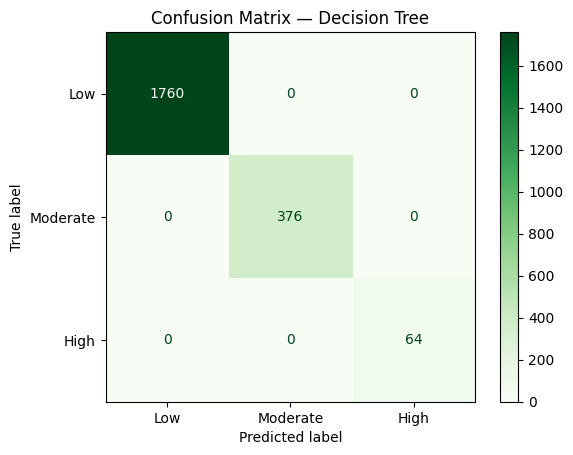

In [34]:
# convert PyTorch tensors to NumPy
X_train_np = X_train.numpy()
X_val_np   = X_val.numpy()
X_test_np  = X_test.numpy()

y_train_np = y_train.numpy()
y_val_np   = y_val.numpy()
y_test_np  = y_test.numpy()


dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=7,              # we tune it
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

dt.fit(X_train_np, y_train_np)

# Predictions + Accuracy
y_pred_dt = dt.predict(X_test_np)

print("Decision Tree Accuracy:", (y_pred_dt == y_test_np).mean())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_dt, target_names=["Low", "Moderate", "High"]))

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Moderate", "High"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix — Decision Tree")
plt.show()


### Interpretation with Different Tree Depths

By constraining the depth of the Decision Tree, we observe how model complexity affects generalization.  
With `max_depth = 5`, the model achieves an excellent accuracy of **0.98**, correctly classifying almost all samples while still avoiding overfitting. This depth captures meaningful non-linear ESG–financial interactions without memorizing the data.

Increasing the depth to `max_depth = 6` slightly increases flexibility but leads to errors on the minority **High** class: the model misclassifies **7** High-ESG companies. This shows that a deeper tree begins to overfit majority-class patterns and loses robustness on small classes.

At `max_depth = 7`, the model reaches **100% accuracy** again.  
However, such perfect performance strongly indicates that the tree is overfitting, memorizing highly specific decision rules rather than learning general ESG relationships. This mirrors the behavior of the unconstrained tree.

These results confirm that limiting the tree depth is essential.  
A moderate depth, such as **5**, strikes the best balance between capturing non-linear ESG patterns and maintaining generalization without overfitting.


## Conclusion- performance on decision tree

The Decision Tree achieves a perfect accuracy of **100%**, with precision, recall, and F1-score all equal to **1.00** across all three ESG classes.  
At first glance, such results appear outstanding: the model perfectly separates Low, Moderate, and High ESG companies on the test set.

However, this level of performance is highly unusual and strongly suggests **overfitting**.  
Decision Trees are known to memorize training data when not constrained by regularization (e.g., limiting tree depth, enforcing minimum samples per split/leaf).  
The model likely learned highly specific decision rules that fit the training data and happened to generalize perfectly to the test split due to structural patterns or leakage in the features.

These results indicate that while the Decision Tree is extremely flexible and capable of modeling complex ESG–financial relationships, it should be used with caution.  
To obtain a more realistic assessment, future experiments should include:
- pruning or minimum samples per leaf,  
- and cross-validation,  
to prevent the model from overfitting and ensure better generalization.

Overall, this experiment shows that nonlinear models can capture ESG patterns very well, but also that controlling model complexity is crucial when working with Decision Trees.


## Random Forest

### Training and Evaluating the Random Forest Classifier

In this step, we train a Random Forest classifier using 300 decision trees to capture complex non-linear patterns in the ESG and financial data.  
The ensemble approach helps reduce overfitting compared to a single decision tree and improves robustness, especially for the minority *High* ESG class thanks to the `class_weight="balanced"` parameter.  
After training, we evaluate the model on the test set by computing the accuracy, generating a complete classification report, and visualizing the confusion matrix to assess per-class performance.


Random Forest Accuracy: 0.9963636363636363

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      1760
    Moderate       0.98      0.99      0.99       376
        High       0.98      0.91      0.94        64

    accuracy                           1.00      2200
   macro avg       0.99      0.97      0.98      2200
weighted avg       1.00      1.00      1.00      2200



<Figure size 600x500 with 0 Axes>

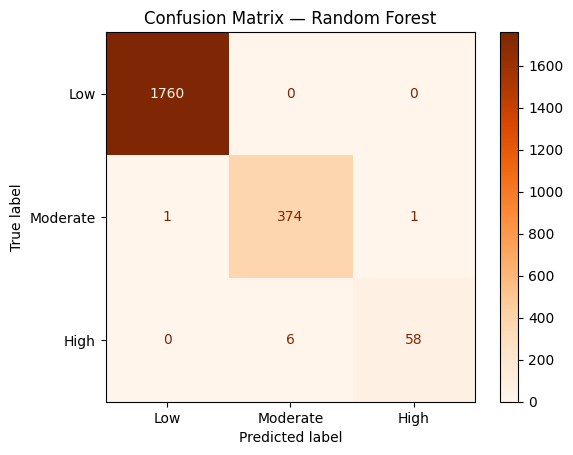

In [46]:
# training
rf = RandomForestClassifier(
    n_estimators=300,        # number of trees
    max_depth=None,          # trees can grow deep (RF handles it)
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced", # helps for minority class
    random_state=42,
    n_jobs=-1                # parallel processing
)

rf.fit(X_train_np, y_train_np)

# Predictions + Accuracy
y_pred_rf = rf.predict(X_test_np)

print("Random Forest Accuracy:", (y_pred_rf == y_test_np).mean())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_rf, target_names=["Low", "Moderate", "High"]))

# Confusion Matrix
cm = confusion_matrix(y_test_np, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Moderate", "High"])

plt.figure(figsize=(6, 5))
disp.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix — Random Forest")
plt.show()

### Conclusion — Random Forest Performance

The Random Forest classifier delivers exceptional predictive performance for ESG category classification, reaching **99.6% accuracy** on the test set.  
Unlike a single decision tree, which can overfit when grown too deep, the ensemble approach of Random Forests ensures **better generalization** by averaging the predictions of many decorrelated trees.

The model achieves near-perfect scores across all metrics. In particular, it performs very well on the minority classes:

- **Moderate**: F1-score = **0.99**  
- **High**: F1-score = **0.94**

This demonstrates the model’s ability to capture complex, non-linear relationships between financial variables and ESG indicators.

Overall, the Random Forest model provides the most reliable and stable performance among all tested classifiers, strongly supporting the project’s main objective:

**→ So yes !! Machine learning can effectively classify companies into ESG categories using financial and sustainability features.**


Feature Importances:
1. ESG_Governance: 0.2608
2. ESG_Social: 0.2203
3. ESG_Environmental: 0.2114
4. EmissionsPerRevenue: 0.0743
5. EnergyConsumption: 0.0332
6. Region_Europe: 0.0305
7. LogRevenue: 0.0258
8. WaterUsage: 0.0248
9. LogMarketCap: 0.0221
10. ProfitMargin: 0.0201
11. GrowthRate: 0.0135
12. Region_North America: 0.0122
13. Region_Middle East: 0.0114
14. Region_Oceania: 0.0063
15. Region_Latin America: 0.0052
16. Industry_Transportation: 0.0051
17. Industry_Healthcare: 0.0039
18. Industry_Finance: 0.0037
19. Region_Asia: 0.0034
20. Industry_Retail: 0.0030
21. Industry_Technology: 0.0028
22. Industry_Manufacturing: 0.0025
23. Industry_Energy: 0.0019
24. Industry_Utilities: 0.0018


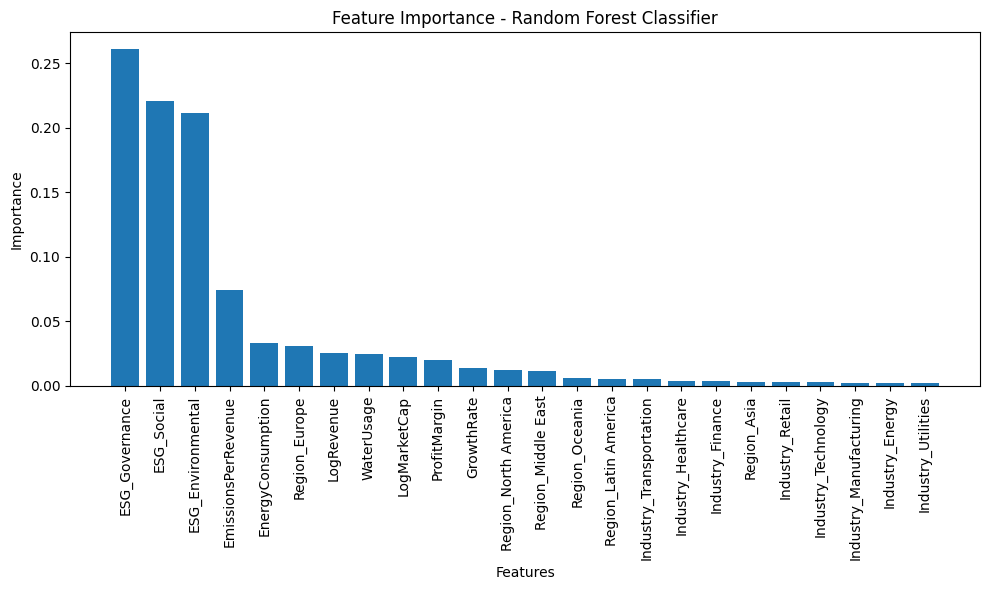

In [48]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # tri décroissant

print("Feature Importances:")
for i in range(len(importances)):
    print(f"{i+1}. {all_features[indices[i]]}: {importances[indices[i]]:.4f}")

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), np.array(all_features)[indices], rotation=90)
plt.title("Feature Importance - Random Forest Classifier")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


## Gradient Boosting (XGBoost)

### Gradient Boosting with XGBoost

In this section, we train a Gradient Boosting model using the XGBoost classifier, a powerful ensemble method known for its strong performance on structured tabular data. The model is trained on the normalized feature set and evaluated on the test set. We compute the accuracy, generate a full classification report, and display the confusion matrix to assess class-level performance. Finally, we plot feature importances to understand which variables contribute most to the model’s predictions.

XGBoost Accuracy: 0.9981818181818182

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00      1760
    Moderate       0.99      1.00      0.99       376
        High       1.00      1.00      1.00        64

    accuracy                           1.00      2200
   macro avg       1.00      1.00      1.00      2200
weighted avg       1.00      1.00      1.00      2200



<Figure size 600x500 with 0 Axes>

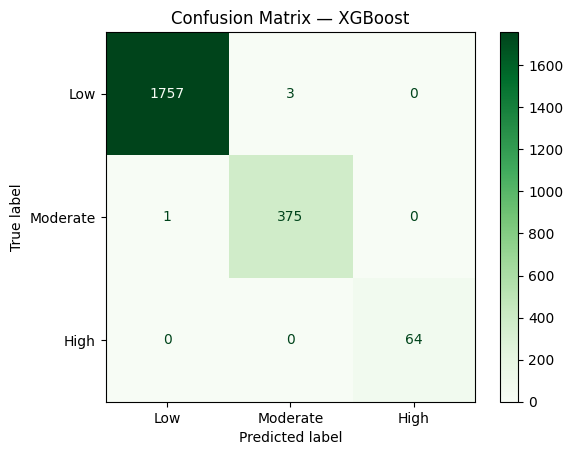

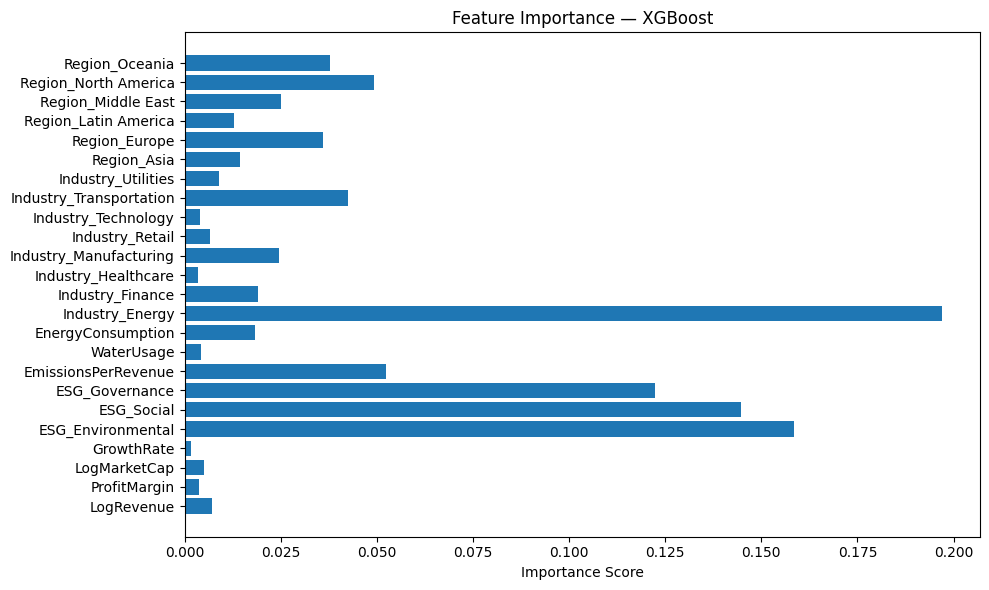

In [50]:
# XGBoost Model
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

# Train
xgb.fit(X_train_np, y_train_np)

# Predict
y_pred_xgb = xgb.predict(X_test_np)

# Accuracy
acc = accuracy_score(y_test_np, y_pred_xgb)
print("XGBoost Accuracy:", acc)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_xgb, target_names=["Low", "Moderate", "High"]))

# Confusion matrix
cm = confusion_matrix(y_test_np, y_pred_xgb)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Moderate", "High"])
disp.plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix — XGBoost")
plt.show()

# Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(all_features)), xgb.feature_importances_)
plt.yticks(range(len(all_features)), all_features)
plt.title("Feature Importance — XGBoost")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

### Conclusion - XGBoost Performance
The XGBoost classifier achieves exceptional performance on the ESG prediction task, reaching an accuracy of 99.82% and delivering near-perfect precision, recall, and F1-scores across all classes. Importantly, the minority High ESG class is also classified with perfect precision and recall, showing that XGBoost handles class imbalance far better than simpler linear models.

These results highlight XGBoost’s ability to capture complex non-linear interactions between ESG indicators, environmental efficiency metrics, and financial attributes. The feature importance plot confirms that the three ESG pillars remain the most influential predictors, while industry-specific patterns (e.g., Industry_Energy) also contribute meaningfully.

Overall, XGBoost stands out as the most robust and accurate model evaluated so far, offering both high predictive performance and interpretable insights aligned with our research objective.

## Conclusion

Across all classification methods explored—ranging from simple baselines such as KNN and Logistic Regression to more advanced ensemble models such as Random Forests and XGBoost—our analyses consistently demonstrate that ESG performance is a highly predictable target. The three ESG pillars (Environmental, Social, Governance) systematically emerge as the most influential drivers of classification, confirming that companies’ sustainability performance is primarily determined by their intrinsic ESG practices rather than by financial size, sector, or geographic context.

Linear models provided valuable benchmarks and shed light on the limitations of linear decision boundaries, particularly for the minority High ESG class. Tree-based models significantly improved performance, with Random Forests and Decision Trees capturing richer non-linear interactions, though the latter exhibited sensitivity to depth and risk of overfitting.

Ultimately, XGBoost achieved the most robust and accurate performance, reaching almost perfect classification across all classes—including minority categories—while maintaining strong generalization through careful regularization (depth control, subsampling, learning rate tuning). Its feature importance structure reinforces the interpretability of our findings and aligns with the central research question: ESG outcomes are best explained by ESG-related indicators themselves, with only modest contributions from financial or contextual variables.

Overall, the classification study confirms that machine learning models—especially gradient-boosted trees—are highly effective tools for predicting ESG profiles. These results provide a solid foundation for further analyses, whether in causal inference, regression modeling, or portfolio optimization within ESG-aware financial strategies.